In [5]:
%matplotlib inline 
%load_ext autoreload 
%autoreload 2

__author__ = 'Song Huang'
__email__ = 'shuang89@ucsc.edu'
__version__ = '170505A'

from __future__ import (print_function, division, absolute_import)

import os
import sys
import math
import glob
import copy
import warnings
import subprocess

import numpy as np
#import seaborn as sns
#sns.set(color_codes=True, style="darkgrid")

# Matplotlib related
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
#mpl.style.use('classic')
plt.rc('text', usetex=True)
#plt.rc('font', family='serif')

from astropy.io import fits
from astropy.table import \
    Table, \
    Column, \
    vstack, \
    unique
    
from astropy.utils.metadata import MergeConflictWarning
warnings.filterwarnings('ignore', category=MergeConflictWarning, 
                        append=True)
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.utils.console import ProgressBar

import hsc_massive
from hsc_massive import \
    s16a_path, \
    sample_selection, \
    prepare_sed, \
    catalog_summary, \
    smhm, \
    plotting

#envir = s16a_path.set_env(version='astro4')
envir = s16a_path.set_env(version='kungpao')

ORG = plotting.ORG
BLK = plotting.BLK
BLU = plotting.BLU
GRN = plotting.GRN

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from kungpao.isophote.ellipse import Ellipse
from kungpao.isophote.ellipse import Centerer
from kungpao.isophote.ellipse import Geometry
from kungpao.isophote.ellipse.model import build_model

In [150]:
import sep

from astropy.visualization import ZScaleInterval, PercentileInterval, AsymmetricPercentileInterval

from scipy.interpolate import LSQUnivariateSpline

In [37]:
IMG_CMAP = plt.get_cmap('viridis')
IMG_CMAP.set_bad(color='black')

SEG_CMAP = plt.get_cmap('tab20')
SEG_CMAP.set_bad(color='white')
SEG_CMAP.set_under(color='white')

# Load Data

In [4]:
gal_img = fits.open('redadd_529_HSC-I_full_img.fits')[0].data
gal_bad = fits.open('redadd_529_HSC-I_full_bad.fits')[0].data
gal_sig = fits.open('redadd_529_HSC-I_full_sig.fits')[0].data

In [22]:
gal_img_swap = gal_img.byteswap().newbyteorder()
gal_sig_swap = gal_sig.byteswap().newbyteorder()
gal_bad_swap = gal_bad.byteswap().newbyteorder()

In [108]:
hsc_pixel_scale = 0.176 # arcsec/ pixel
hsc_zeropoint = 27.0    # mag

print("# 10 arcsecs == %d pixels" % (10.0 / hsc_pixel_scale))

print("# 0.01/pixel == %6.3f mag/arcsec^2" % (
    -2.5 * np.log10(0.01 / (hsc_pixel_scale ** 2.0)) + hsc_zeropoint)
     )

# 10 arcsecs == 56 pixels
# 0.01/pixel == 28.228 mag/arcsec^2


# Initial Test

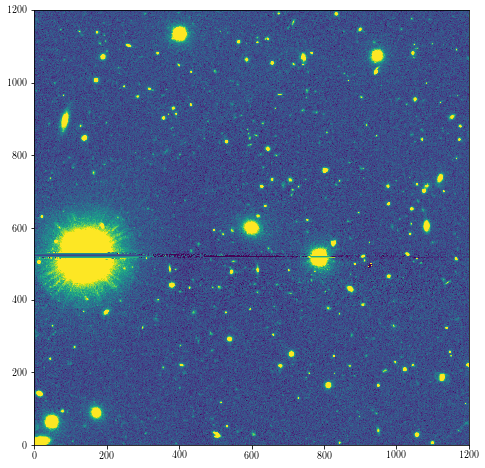

In [117]:
plt.figure(figsize=(8, 8))

gal_img_zscale = np.arcsinh(gal_img)

zmin, zmax = ZScaleInterval(contrast=0.15).get_limits(gal_img_zscale)

plt.imshow(gal_img_zscale, origin='lower', cmap=IMG_CMAP,
           vmin=zmin, vmax=zmax)

# Detect 455 objects


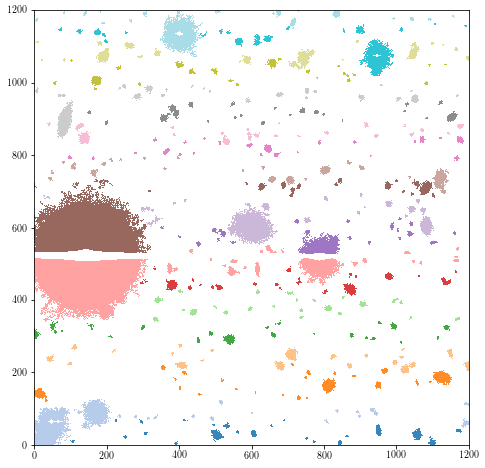

In [118]:
objects, seg = sep.extract(gal_img_swap, 2.0,
                           err=gal_sig_swap, mask=gal_bad_swap,
                           minarea=20, 
                           deblend_nthresh=24, deblend_cont=0.005,
                           clean=True, clean_param=1.0,
                           segmentation_map=True)

seg_mask = ((seg > 0) | 
            (gal_bad > 0))

print("# Detect %d objects" % len(objects))

plt.figure(figsize=(8, 8))

plt.imshow(seg, origin='lower', cmap=SEG_CMAP, 
           vmin=1, alpha=0.9)

# Mean Sky / RMS Sky =   -0.00154 /    0.05532


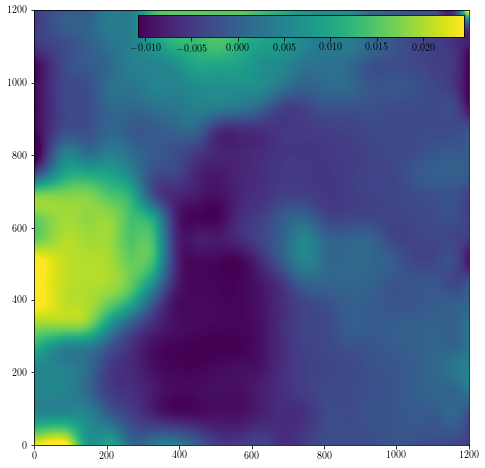

In [119]:
bkg = sep.Background(gal_img_swap, 
                     mask=seg_mask, maskthresh=0,
                     bw=60, bh=60, 
                     fw=4, fh=4)

print("# Mean Sky / RMS Sky = %10.5f / %10.5f" % (bkg.globalback, bkg.globalrms))


fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(111)

sky_zscale = np.arcsinh(bkg.back())

zmin, zmax = ZScaleInterval(contrast=0.15).get_limits(sky_zscale)

plt.imshow(sky_zscale, origin='lower', cmap=IMG_CMAP, 
           vmin=zmin, vmax=zmax)

ax_cbar = inset_axes(ax1, width="75%", height="5%", loc=1) 
plt.colorbar(cax=ax_cbar, orientation='horizontal')

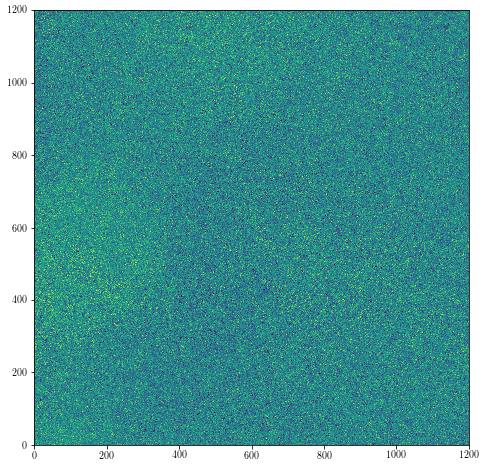

In [120]:
sky_noise_add = np.random.normal(loc=bkg.back(), 
                                 scale=bkg.rms(), 
                                 size=gal_img.shape)

plt.figure(figsize=(8, 8))

sky_noise_zscale = np.arcsinh(sky_noise_add)

zmin, zmax = ZScaleInterval(contrast=0.15).get_limits(sky_noise_zscale)

plt.imshow(sky_noise_zscale, origin='lower', cmap=IMG_CMAP, 
           vmin=zmin, vmax=zmax)

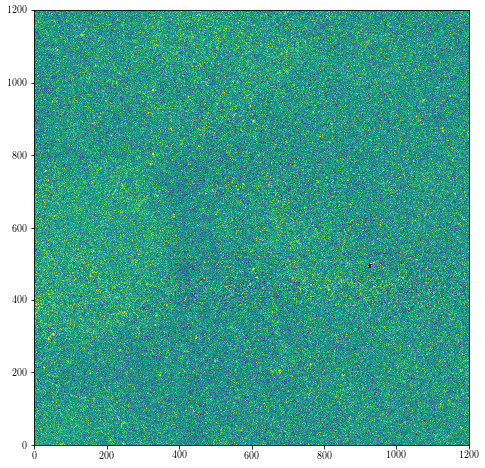

In [121]:
img_noise_replace = copy.deepcopy(gal_img)
img_noise_replace[seg_mask] = sky_noise_add[seg_mask]

plt.figure(figsize=(8, 8))

img_noise_zscale = np.arcsinh(img_noise_replace)

zmin, zmax = ZScaleInterval(contrast=0.15).get_limits(img_noise_zscale)

plt.imshow(img_noise_zscale, origin='lower', cmap=IMG_CMAP, 
           vmin=zmin, vmax=zmax)

# Detect 322 objects on the noise-replaced image


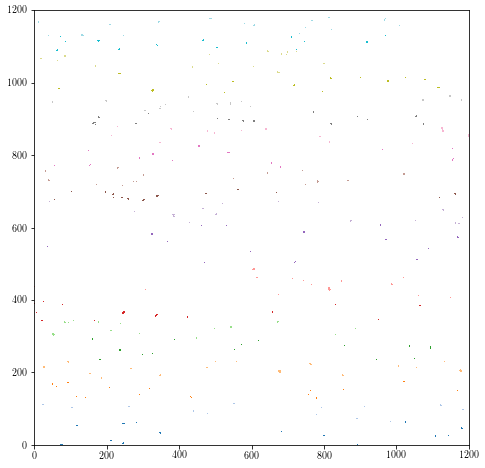

In [123]:
objects_hot, seg_hot = sep.extract(img_noise_replace.byteswap().newbyteorder(), 3.5,
                                   err=gal_sig_swap,
                                   minarea=5, 
                                   deblend_nthresh=24, deblend_cont=0.003,
                                   clean=True, clean_param=1.0,
                                   segmentation_map=True)

seg_mask_hot = seg_hot > 0

print("# Detect %d objects on the noise-replaced image" % len(objects_hot))

plt.figure(figsize=(8, 8))

plt.imshow(seg_hot, origin='lower', cmap=SEG_CMAP, 
           vmin=1)

In [124]:
def seg_remove_cen_obj(seg):
    """
    Remove the central object from the segmentation.
    """
    seg_copy = copy.deepcopy(seg)
    seg_copy[seg == seg[int(seg.shape[0] / 2L), int(seg.shape[1] / 2L)]] = 0
    
    return seg_copy

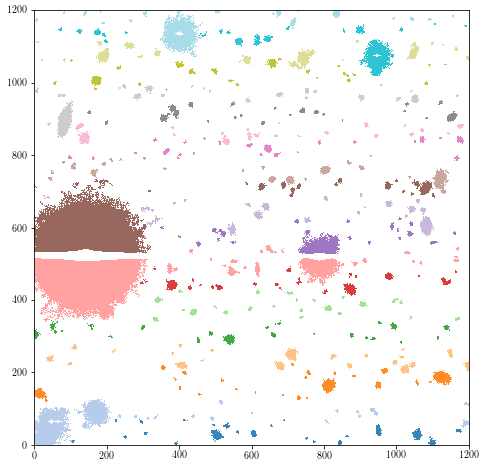

In [125]:
seg_nocen = seg_remove_cen_obj(seg)

plt.figure(figsize=(8, 8))

plt.imshow(seg_nocen, origin='lower', cmap=SEG_CMAP, 
           vmin=1, alpha=0.9)

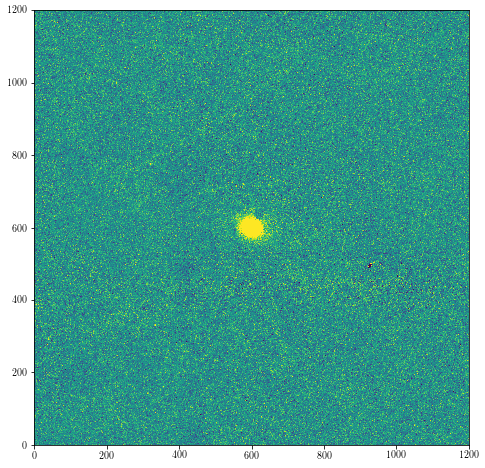

In [132]:
seg_mask_nocen = ((seg_nocen > 0) | 
                  (gal_bad > 0))

img_noise_nocen = copy.deepcopy(gal_img)
img_noise_nocen[seg_mask_nocen] = sky_noise_add[seg_mask_nocen]

img_noise_nocen[seg_mask_hot] = sky_noise_add[seg_mask_hot]

plt.figure(figsize=(8, 8))

img_noise_nocen_zscale = np.arcsinh(img_noise_nocen - bkg.back())

zmin, zmax = ZScaleInterval(contrast=0.15).get_limits(img_noise_nocen_zscale)

plt.imshow(img_noise_nocen_zscale, origin='lower', cmap=IMG_CMAP, 
           vmin=zmin, vmax=zmax)

## Check the differences in profile

In [146]:
obj1_geom = Geometry(600.0, 600.0, 4., 0.05, 10./180.*np.pi)

obj1_nomsk_ellip = Ellipse(gal_img, geometry=obj1_geom)

obj1_clean_ellip = Ellipse((img_noise_nocen - bkg.back()), geometry=obj1_geom)

gal_img_msk = copy.deepcopy(gal_img - bkg.back())
gal_img_msk[seg_mask_nocen] = np.nan

obj1_bgmsk_ellip = Ellipse(gal_img_msk, geometry=obj1_geom)

Centering on object....   
Done. Found x0 = 600.0, y0 = 600.0
Centering on object....   
Done. Found x0 = 600.0, y0 = 600.0
Centering on object....   
Done. Found x0 = 600.0, y0 = 600.0


In [134]:
obj1_nomsk_iso = obj1_nomsk_ellip.fit_image(sma0=1.0, minsma=0.0, maxsma=250.0, 
                                            step=0.15, linear=False, integrmode='bi-linear', 
                                            sclip=3., nclip=3, 
                                            conver=0.06, maxit=60, fflag=0.7,
                                            fixgeom=False)

#
# Semi-      Isophote         Ellipticity    Position     Grad.   Data  Flag Iter. Stop
# major        mean                           Angle        rel.                    code
# axis       intensity                                    error
#(pixel)                                     (degree)
#
   1.00       41.18 ( 0.09)  0.069 (0.010) 148.47 ( 4.6)  0.141    13     0   60     2
   1.15       39.83 ( 0.08)  0.079 (0.007) 148.47 ( 2.8)  0.106    13     0   60     2
   1.32       38.18 ( 0.09)  0.082 (0.006) 146.66 ( 2.4)  0.086    13     0   10     0
   1.52       36.00 ( 0.08)  0.079 (0.005) 146.73 ( 2.0)  0.064    13     0   10     0
   1.75       33.38 ( 0.05)  0.070 (0.003) 147.52 ( 1.2)  0.035    13     0   14     0
   2.01       30.56 ( 0.04)  0.076 (0.002) 147.52 ( 0.7)  0.032    13     0   60     2
   2.31       27.61 ( 0.04)  0.088 (0.002) 149.31 ( 0.6)  0.028    14     0   10     0
   2.66       24.25 ( 0.02)  0.086 (0.001) 146.33 ( 0.3)  0.015    16     0   10     0
   3.0

In [135]:
obj1_clean_iso = obj1_clean_ellip.fit_image(sma0=1.0, minsma=0.0, maxsma=250.0, 
                                            step=0.15, linear=False, integrmode='bi-linear', 
                                            sclip=3., nclip=1, 
                                            conver=0.06, maxit=60, fflag=0.7,
                                            fixgeom=False)

#
# Semi-      Isophote         Ellipticity    Position     Grad.   Data  Flag Iter. Stop
# major        mean                           Angle        rel.                    code
# axis       intensity                                    error
#(pixel)                                     (degree)
#
   1.00       41.18 ( 0.09)  0.069 (0.010) 148.47 ( 4.6)  0.141    13     0   60     2
   1.15       39.84 ( 0.08)  0.079 (0.007) 148.47 ( 2.8)  0.106    13     0   60     2
   1.32       38.18 ( 0.09)  0.082 (0.006) 146.66 ( 2.4)  0.086    13     0   10     0
   1.52       36.00 ( 0.08)  0.079 (0.005) 146.73 ( 2.0)  0.064    13     0   10     0
   1.75       33.39 ( 0.05)  0.070 (0.003) 147.52 ( 1.2)  0.035    13     0   14     0
   2.01       30.56 ( 0.04)  0.076 (0.002) 147.52 ( 0.7)  0.032    13     0   60     2
   2.31       27.62 ( 0.04)  0.088 (0.002) 149.31 ( 0.6)  0.028    14     0   10     0
   2.66       24.25 ( 0.02)  0.086 (0.001) 146.33 ( 0.3)  0.015    16     0   10     0
   3.0

In [147]:
obj1_bgmsk_iso = obj1_bgmsk_ellip.fit_image(sma0=1.0, minsma=0.0, maxsma=250.0, 
                                            step=0.15, linear=False, integrmode='bi-linear', 
                                            sclip=3., nclip=3, 
                                            conver=0.06, maxit=60, fflag=0.7,
                                            fixgeom=False)

#
# Semi-      Isophote         Ellipticity    Position     Grad.   Data  Flag Iter. Stop
# major        mean                           Angle        rel.                    code
# axis       intensity                                    error
#(pixel)                                     (degree)
#
   1.00       41.18 ( 0.09)  0.069 (0.010) 148.47 ( 4.6)  0.141    13     0   60     2
   1.15       39.84 ( 0.08)  0.079 (0.007) 148.47 ( 2.8)  0.106    13     0   60     2
   1.32       38.18 ( 0.09)  0.082 (0.006) 146.66 ( 2.4)  0.086    13     0   10     0
   1.52       36.00 ( 0.08)  0.079 (0.005) 146.73 ( 2.0)  0.064    13     0   10     0
   1.75       33.39 ( 0.05)  0.070 (0.003) 147.52 ( 1.2)  0.035    13     0   14     0
   2.01       30.56 ( 0.04)  0.076 (0.002) 147.52 ( 0.7)  0.032    13     0   60     2
   2.31       27.62 ( 0.04)  0.088 (0.002) 149.31 ( 0.6)  0.028    14     0   10     0
   2.66       24.25 ( 0.02)  0.086 (0.001) 146.33 ( 0.3)  0.015    16     0   10     0
   3.0

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in log10
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in log10
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in log10


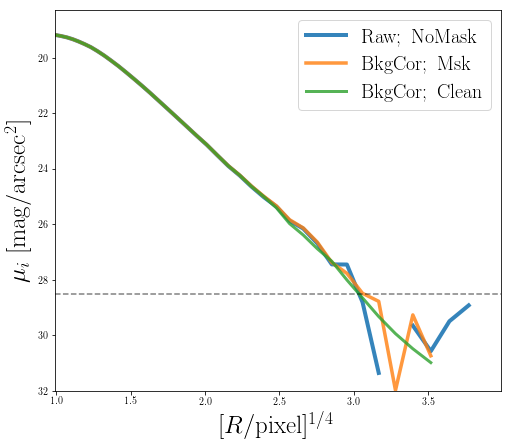

In [159]:
fig = plt.figure(figsize=(8, 7))

ax1 = fig.add_subplot(111)

ax1.plot(obj1_nomsk_iso.sma ** 0.25, 
         (-2.5 * np.log10(obj1_nomsk_iso.intens / (hsc_pixel_scale ** 2.0)) + hsc_zeropoint),
         label=r'$\mathrm{Raw;\ NoMask}$', 
         linewidth=4.0, alpha=0.9)

ax1.plot(obj1_bgmsk_iso.sma ** 0.25, 
         (-2.5 * np.log10(obj1_bgmsk_iso.intens / (hsc_pixel_scale ** 2.0)) + hsc_zeropoint),
         label=r'$\mathrm{BkgCor;\ Msk}$', 
         linewidth=3.5, alpha=0.8)

#----------------------------------------------------------------------------------------#
rsma = obj1_clean_iso.sma ** 0.25
sbp = (-2.5 * np.log10(obj1_clean_iso.intens / (hsc_pixel_scale ** 2.0)) + hsc_zeropoint)

rsma = rsma[0: np.max(np.argwhere(np.isfinite(sbp)))]
sbp = sbp[0: np.max(np.argwhere(np.isfinite(sbp)))]

flag_use = np.isfinite(sbp)

rsma_use = rsma[np.isfinite(sbp)]
sbp_use = sbp[np.isfinite(sbp)]
nodes = rsma_use[2:-2]

sbp_intrp = LSQUnivariateSpline(rsma_use, sbp_use, nodes)(rsma)
sbp[~flag_use] = sbp_intrp[~flag_use]
#----------------------------------------------------------------------------------------#

ax1.plot(rsma, sbp,
         label=r'$\mathrm{BkgCor;\ Clean}$', 
         linewidth=3.0, alpha=0.8)

ax1.legend(fontsize=20)

ax1.axhline(28.5, linestyle='--', c='k', alpha=0.5)

ax1.set_ylim(31.99, 18.29)
ax1.set_xlim(0.99, 3.99)

ax1.set_xlabel(r'$[R/\mathrm{pixel}]^{1/4}$', fontsize=25)
ax1.set_ylabel(r'$\mu_{i}\ [\mathrm{mag}/\mathrm{arcsec}^2]$', fontsize=25)

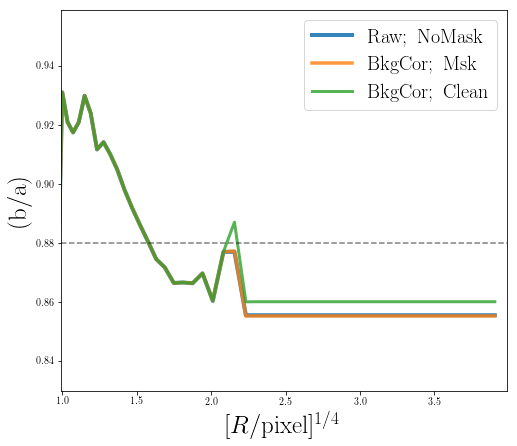

In [179]:
fig = plt.figure(figsize=(8, 7))

ax1 = fig.add_subplot(111)

ax1.plot(obj1_nomsk_iso.sma ** 0.25, 
         1.0 - obj1_nomsk_iso.eps,
         label=r'$\mathrm{Raw;\ NoMask}$', 
         linewidth=4.0, alpha=0.9)

ax1.plot(obj1_bgmsk_iso.sma ** 0.25, 
         1.0 - obj1_bgmsk_iso.eps,
         label=r'$\mathrm{BkgCor;\ Msk}$', 
         linewidth=3.5, alpha=0.8)

ax1.plot(obj1_clean_iso.sma ** 0.25, 
         1.0 - obj1_clean_iso.eps,
         label=r'$\mathrm{BkgCor;\ Clean}$', 
         linewidth=3.0, alpha=0.8)

ax1.legend(fontsize=20)

ax1.axhline(0.88, linestyle='--', c='k', alpha=0.5)

ax1.set_ylim(0.83, 0.959)
ax1.set_xlim(0.99, 3.99)

ax1.set_xlabel(r'$[R/\mathrm{pixel}]^{1/4}$', fontsize=25)
ax1.set_ylabel(r'$(\mathrm{b}/\mathrm{a})$', fontsize=25)

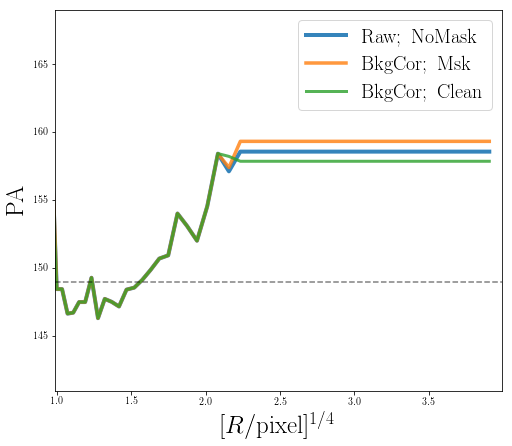

In [178]:
fig = plt.figure(figsize=(8, 7))

ax1 = fig.add_subplot(111)

ax1.plot(obj1_nomsk_iso.sma ** 0.25, 
         obj1_nomsk_iso.pa * 180.0 / np.pi,
         label=r'$\mathrm{Raw;\ NoMask}$', 
         linewidth=4.0, alpha=0.9)

ax1.plot(obj1_bgmsk_iso.sma ** 0.25, 
         obj1_bgmsk_iso.pa * 180.0 / np.pi,
         label=r'$\mathrm{BkgCor;\ Msk}$', 
         linewidth=3.5, alpha=0.8)

ax1.plot(obj1_clean_iso.sma ** 0.25, 
         obj1_clean_iso.pa * 180.0 / np.pi,
         label=r'$\mathrm{BkgCor;\ Clean}$', 
         linewidth=3.0, alpha=0.8)

ax1.legend(fontsize=20)

ax1.axhline(149, linestyle='--', c='k', alpha=0.5)

ax1.set_xlim(0.99, 3.99)
ax1.set_ylim(141, 169)

ax1.set_xlabel(r'$[R/\mathrm{pixel}]^{1/4}$', fontsize=25)
ax1.set_ylabel(r'$\mathrm{PA}$', fontsize=25)

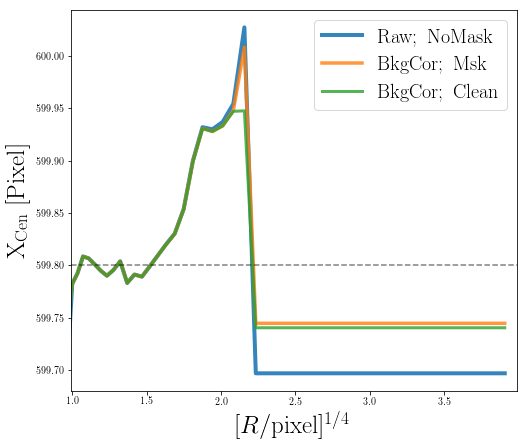

In [174]:
fig = plt.figure(figsize=(8, 7))

ax1 = fig.add_subplot(111)

ax1.plot(obj1_nomsk_iso.sma ** 0.25, 
         obj1_nomsk_iso.x0,
         label=r'$\mathrm{Raw;\ NoMask}$', 
         linewidth=4.0, alpha=0.9)

ax1.plot(obj1_bgmsk_iso.sma ** 0.25, 
         obj1_bgmsk_iso.x0,
         label=r'$\mathrm{BkgCor;\ Msk}$', 
         linewidth=3.5, alpha=0.8)

ax1.plot(obj1_clean_iso.sma ** 0.25, 
         obj1_clean_iso.x0,
         label=r'$\mathrm{BkgCor;\ Clean}$', 
         linewidth=3.0, alpha=0.8)

ax1.legend(fontsize=20)

ax1.axhline(599.80, linestyle='--', c='k', alpha=0.5)

ax1.set_xlim(0.99, 3.99)
#ax1.set_ylim(141, 169)

ax1.set_xlabel(r'$[R/\mathrm{pixel}]^{1/4}$', fontsize=25)
ax1.set_ylabel(r'$\mathrm{X_{\mathrm{Cen}}}\ [\mathrm{Pixel}]$', fontsize=25)

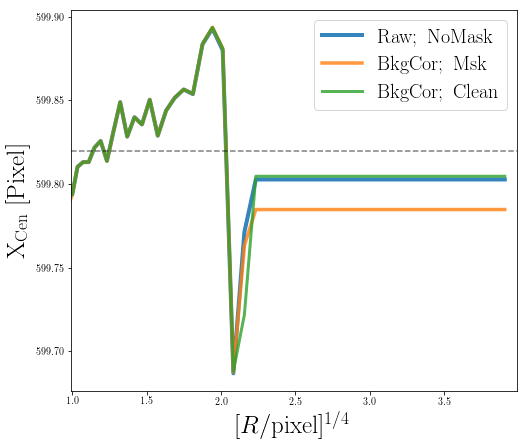

In [177]:
fig = plt.figure(figsize=(8, 7))

ax1 = fig.add_subplot(111)

ax1.plot(obj1_nomsk_iso.sma ** 0.25, 
         obj1_nomsk_iso.y0,
         label=r'$\mathrm{Raw;\ NoMask}$', 
         linewidth=4.0, alpha=0.9)

ax1.plot(obj1_bgmsk_iso.sma ** 0.25, 
         obj1_bgmsk_iso.y0,
         label=r'$\mathrm{BkgCor;\ Msk}$', 
         linewidth=3.5, alpha=0.8)

ax1.plot(obj1_clean_iso.sma ** 0.25, 
         obj1_clean_iso.y0,
         label=r'$\mathrm{BkgCor;\ Clean}$', 
         linewidth=3.0, alpha=0.8)

ax1.legend(fontsize=20)

ax1.axhline(599.82, linestyle='--', c='k', alpha=0.5)

ax1.set_xlim(0.99, 3.99)
#ax1.set_ylim(141, 169)

ax1.set_xlabel(r'$[R/\mathrm{pixel}]^{1/4}$', fontsize=25)
ax1.set_ylabel(r'$\mathrm{X_{\mathrm{Cen}}}\ [\mathrm{Pixel}]$', fontsize=25)

In [182]:
obj1_geom_fix = Geometry(599.80, 599.82, 2., 0.12, (149.0 / 180.0 * np.pi))

obj1_nomsk_ellip_fix = Ellipse(gal_img, geometry=obj1_geom_fix)

obj1_bgmsk_ellip_fix = Ellipse(gal_img_msk, geometry=obj1_geom_fix)

obj1_clean_ellip_fix = Ellipse((img_noise_nocen - bkg.back()), geometry=obj1_geom_fix)

Centering on object....   
Done. Found x0 = 600.0, y0 = 600.0
Centering on object....   
Done. Found x0 = 600.0, y0 = 600.0
Centering on object....   
Done. Found x0 = 600.0, y0 = 600.0


In [183]:
obj1_nomsk_iso_fix = obj1_nomsk_ellip_fix.fit_image(sma0=1.0, minsma=0.0, maxsma=300.0, 
                                                    step=0.15, linear=False, integrmode='bi-linear', 
                                                    sclip=3., nclip=3, 
                                                    conver=0.06, maxit=60, fflag=0.7,
                                                    fixgeom=True)

obj1_bgmsk_iso_fix = obj1_bgmsk_ellip_fix.fit_image(sma0=1.0, minsma=0.0, maxsma=300.0, 
                                                    step=0.15, linear=False, integrmode='bi-linear', 
                                                    sclip=3., nclip=3, 
                                                    conver=0.06, maxit=60, fflag=0.7,
                                                    fixgeom=True)

obj1_clean_iso_fix = obj1_clean_ellip_fix.fit_image(sma0=1.0, minsma=0.0, maxsma=300.0, 
                                                    step=0.15, linear=False, integrmode='bi-linear', 
                                                    sclip=3., nclip=1, 
                                                    conver=0.06, maxit=60, fflag=0.7,
                                                    fixgeom=True)

#
# Semi-      Isophote         Ellipticity    Position     Grad.   Data  Flag Iter. Stop
# major        mean                           Angle        rel.                    code
# axis       intensity                                    error
#(pixel)                                     (degree)
#
   1.00       40.34 ( 0.89)  0.120 (0.160) 149.00 (43.3)  1.371    13     0    0     4
   1.15       39.33 ( 0.86)  0.120 (0.143) 149.00 (38.9)  2.749    13     0    0     4
   1.32       37.84 ( 0.80)  0.120 (0.055) 149.00 (14.9)  1.235    13     0    0     4
   1.52       35.94 ( 0.72)  0.120 (0.026) 149.00 ( 7.2)  0.765    13     0    0     4
   1.75       33.68 ( 0.66)  0.120 (0.011) 149.00 ( 2.9)  0.552    13     0    0     4
   2.01       31.08 ( 0.66)  0.120 (0.002) 149.00 ( 0.7)  0.421    13     0    0     4
   2.31       28.24 ( 0.63)  0.120 (0.007) 149.00 ( 2.0)  0.338    14     0    0     4
   2.66       25.17 ( 0.65)  0.120 (0.011) 149.00 ( 3.0)  0.282    16     0    0     4
   3.0

  24.89        0.38 ( 0.00)  0.120 (0.002) 149.00 ( 0.4)  0.072   135     1    0     4
  28.63        0.26 ( 0.00)  0.120 (0.002) 149.00 ( 0.4)  0.095   155     1    0     4
  32.92        0.18 ( 0.00)  0.120 (0.001) 149.00 ( 0.2)  None    178     1    0     4
  37.86        0.12 ( 0.00)  0.120 (0.001) 149.00 ( 0.1)  None    205     1    0     4
  43.54        0.07 ( 0.00)  0.120 (0.000) 149.00 ( 0.1)  None    235     1    0     4
  50.07        0.05 ( 0.00)  0.120 (0.000) 149.00 ( 0.1)  None    271     1    0     4
  57.58        0.04 ( 0.00)  0.120 (0.000) 149.00 ( 0.0)  None    311     1    0     4
  66.21        0.02 ( 0.00)  0.120 (0.000) 149.00 ( 0.0)  None    358     1    0     4
  76.14        0.01 ( 0.00)  0.120 (0.000) 149.00 ( 0.0)  None    411     1    0     4
  87.57        0.01 ( 0.00)  0.120 (0.000) 149.00 ( 0.0)  None    473     1    0     4
 100.70        0.00 ( 0.00)  0.120 (0.000) 149.00 ( 0.0)  None    544     1    0     4
 115.80        0.00 ( 0.00)  0.120 (0.000) 

In [188]:
print(-2.5 * np.log10(np.nanmax(obj1_nomsk_iso_fix.tflux_e)) + 27.0,
      -2.5 * np.log10(np.nanmax(obj1_bgmsk_iso_fix.tflux_e)) + 27.0,
      -2.5 * np.log10(np.nanmax(obj1_clean_iso_fix.tflux_e)) + 27.0)

print(-2.5 * np.log10(np.nanmax(obj1_nomsk_iso.tflux_e)) + 27.0,
      -2.5 * np.log10(np.nanmax(obj1_bgmsk_iso.tflux_e)) + 27.0,
      -2.5 * np.log10(np.nanmax(obj1_clean_iso.tflux_e)) + 27.0)

16.6327923485 17.9427113685 17.7274289763
16.7076329795 17.9466574231 17.7278903491


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in log10
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in log10
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in log10


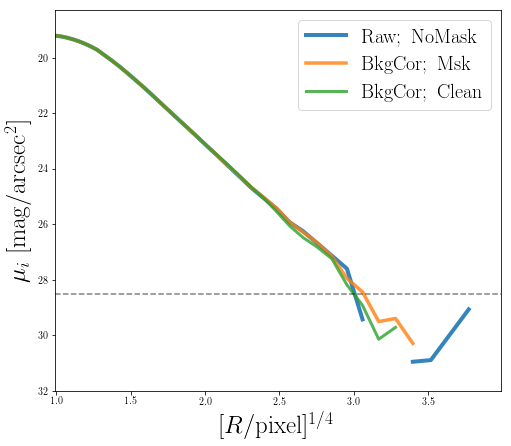

In [184]:
fig = plt.figure(figsize=(8, 7))

ax1 = fig.add_subplot(111)

ax1.plot(obj1_nomsk_iso_fix.sma ** 0.25, 
         (-2.5 * np.log10(obj1_nomsk_iso_fix.intens / (hsc_pixel_scale ** 2.0)) + hsc_zeropoint),
         label=r'$\mathrm{Raw;\ NoMask}$', 
         linewidth=4.0, alpha=0.9)

ax1.plot(obj1_bgmsk_iso_fix.sma ** 0.25, 
         (-2.5 * np.log10(obj1_bgmsk_iso_fix.intens / (hsc_pixel_scale ** 2.0)) + hsc_zeropoint),
         label=r'$\mathrm{BkgCor;\ Msk}$', 
         linewidth=3.5, alpha=0.8)

#----------------------------------------------------------------------------------------#
rsma = obj1_clean_iso_fix.sma ** 0.25
sbp = (-2.5 * np.log10(obj1_clean_iso_fix.intens / (hsc_pixel_scale ** 2.0)) + hsc_zeropoint)

rsma = rsma[0: np.max(np.argwhere(np.isfinite(sbp)))]
sbp = sbp[0: np.max(np.argwhere(np.isfinite(sbp)))]

flag_use = np.isfinite(sbp)

rsma_use = rsma[np.isfinite(sbp)]
sbp_use = sbp[np.isfinite(sbp)]
nodes = rsma_use[2:-2]

sbp_intrp = LSQUnivariateSpline(rsma_use, sbp_use, nodes)(rsma)
sbp[~flag_use] = sbp_intrp[~flag_use]
#----------------------------------------------------------------------------------------#

ax1.plot(rsma, sbp,
         label=r'$\mathrm{BkgCor;\ Clean}$', 
         linewidth=3.0, alpha=0.8)

ax1.legend(fontsize=20)

ax1.axhline(28.5, linestyle='--', c='k', alpha=0.5)

ax1.set_ylim(31.99, 18.29)
ax1.set_xlim(0.99, 3.99)

ax1.set_xlabel(r'$[R/\mathrm{pixel}]^{1/4}$', fontsize=25)
ax1.set_ylabel(r'$\mu_{i}\ [\mathrm{mag}/\mathrm{arcsec}^2]$', fontsize=25)

# TODO List

    - [ ] Identify central object, do not remove from segmentation image
    - [ ] Identify objects within the inner region, do not remove them from the segmentation image
    - [ ] For brighter objects, grow the footprint a little bit 
    - [ ] 